# Imports + Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.figsize':(11,7), 
    'figure.dpi':120
})
image_dest = 'results_images/'
visual_specs={'fontsize':14, 'palette':'Greys', 'saturation':0.5}
fontsize = visual_specs['fontsize']
palette = visual_specs['palette']
datapath = '../Data/'

id_col = 'SPA_PER_ID'
event_col = 'CMIS_MATCH'

# Load Predictions

In [2]:
def load_model_output(filepath: str):
    infile = open(filepath, 'rb')
    model_output = pickle.load(infile)
    infile.close()
    return model_output['Performance'], model_output['Models'], model_output['Features']

def print_list(list_to_print: list):
    for item in list_to_print:
        print(item)
    print()
    return

In [3]:
"""filename = 'output_original.pickle'
summary1, models1, features1 = load_model_output(datapath+filename)
print('Original Features')
print_list(features1)

filename = 'output_cur_balance.pickle'
summary2, models2, features2 = load_model_output(datapath+filename)
print('Current Balance Features')
print_list(features2)"""

filename = 'output_reduced.pickle'
summary3, models3, features3 = load_model_output(datapath+filename)
print('Reduced Features')
print_list(features3)

"""filename = 'output_bill.pickle'
summary4, models4, features4 = load_model_output(datapath+filename)
print('Bill Features')
print_list(features4)"""

Reduced Features
PAST_DUE
TOTAL_CUR_BALANCE
NUM_PREM_FOR_PER
BREAK_ARRANGEMENT
NUM_PER_FOR_PREM
PER-PREM-MONTH_ID
CMIS_MATCH



"filename = 'output_bill.pickle'\nsummary4, models4, features4 = load_model_output(datapath+filename)\nprint('Bill Features')\nprint_list(features4)"

# ROC Curve

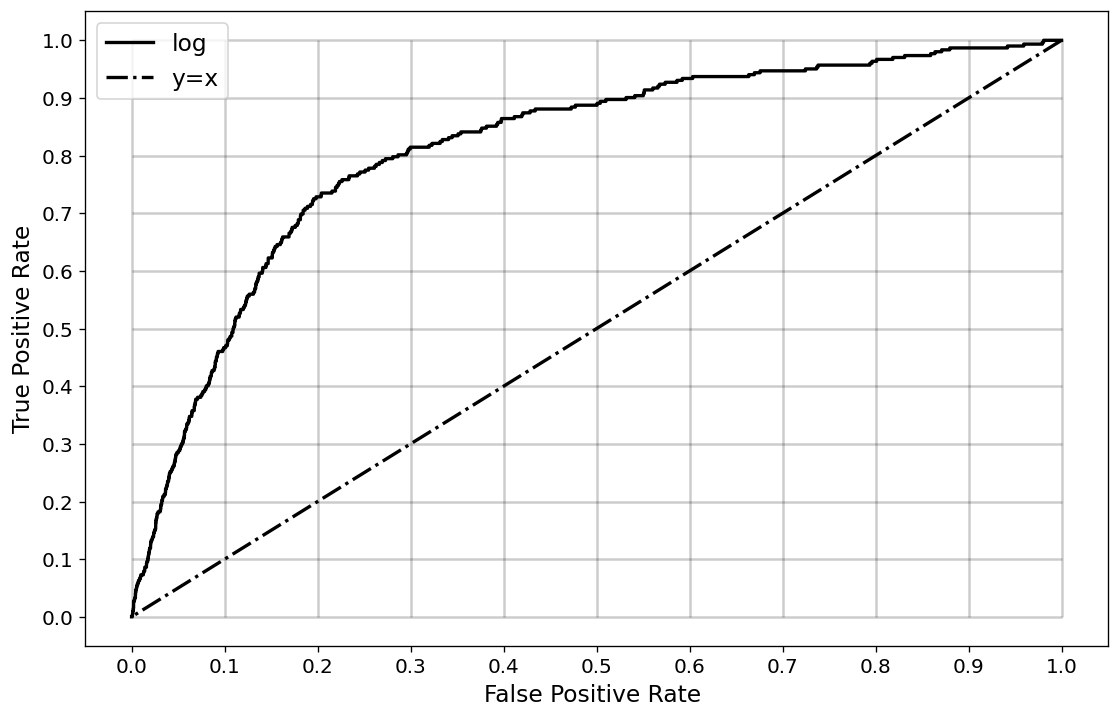

In [4]:
linewidth = 2
color = 'black'
alpha=0.2

# Original
# plt.plot(summary1['fpr'], summary1['tpr'], color='black', label='log', linestyle='dotted', linewidth=linewidth)

# 'TOTAL_CUR_BALANCE' instead of 'TOTAL_60_DAYS_AMT'
# plt.plot(summary2['fpr'], summary2['tpr'], color='black', label='cur_balance', linestyle='-', linewidth=linewidth)

# Reduced to only ubiquituous features.
plt.plot(summary3['fpr'], summary3['tpr'], color='black', label='log', linestyle='-', linewidth=linewidth)

# Only billing
# plt.plot(summary4['fpr'], summary4['tpr'], color='black', label='billing', linestyle='--', linewidth=linewidth)


# Refernce line
plt.plot([1, 0], [1, 0], color='black', label='y=x', linestyle='dashdot', linewidth=linewidth)

ticks = np.arange(0, 1.1, 0.1)
plt.hlines(y=ticks, xmin=0, xmax=1, colors=color, alpha=alpha)
plt.vlines(x=ticks, ymin=0, ymax=1, colors=color, alpha=alpha)
plt.xlabel('False Positive Rate ', fontsize=fontsize)
plt.xticks(ticks, fontsize=fontsize-2)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.yticks(ticks, fontsize=fontsize-2)
plt.legend(fontsize=fontsize)
# plt.savefig(fname=image_dest+'ROC.png', bbox_inches='tight')
plt.show()

# Analyze Models

In [5]:
float_format = "%.3f"
features_to_drop = ['PER-PREM-MONTH_ID', 'CMIS_MATCH']
xname = [x for x in features3 if x not in features_to_drop]

In [6]:
models3[0].summary(yname='CMIS_MATCH', xname=xname)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             CMIS_MATCH   No. Observations:              2423288
Model:                          Logit   Df Residuals:                  2423283
Method:                           MLE   Df Model:                            4
Date:                Fri, 10 Dec 2021   Pseudo R-squ.:                 0.05946
Time:                        14:44:07   Log-Likelihood:                -41350.
converged:                       True   LL-Null:                       -43964.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
PAST_DUE              0.3101      0.004     78.079      0.000       0.302       0.318
TOTAL_CUR_BALANCE     0.0002    9.4e-06     22.073      0.000       0.000       0.000
NUM_PREM_FOR_PER     -6.2334      0.036   -175.415      0.000      -6.303      -6.164
BREAK_ARRANGEMENT     0.5253      0.049     10.775      0.000       0.430       0.621
NUM_PER_FOR_PREM     -0.1459      0.028     -5.298      0.000      -0.200      -0.092
=====================================================================================
"""

In [47]:
def avg_params(models, xname):
    params = np.zeros(shape=len(xname))
    conf_int = np.zeros(shape=(len(xname), 2))
    k = len(models)
    for model in models:
        params = np.add(params, model.params)
        conf_int = np.add(conf_int, model.conf_int())
    params = np.divide(params, k)
    conf_int = np.divide(conf_int, k)
    df = pd.DataFrame(data={'Feature': xname,
                            'Mean Coeff': params,
                            'Mean OR': np.exp(params),
                            'Mean [0.025': np.exp(conf_int[:, 0]),
                            'Mean 0.975]': np.exp(conf_int[:, 1])})
    return df

In [48]:
avg_params3 = avg_params(models=models3, xname=xname)

print(avg_params3.to_latex(float_format=float_format, index=False))

\begin{tabular}{lrrrr}
\toprule
          Feature &  Mean Coeff &  Mean OR &  Mean [0.025 &  Mean 0.975] \\
\midrule
         PAST\_DUE &       0.309 &    1.362 &        1.351 &        1.373 \\
TOTAL\_CUR\_BALANCE &       0.000 &    1.000 &        1.000 &        1.000 \\
 NUM\_PREM\_FOR\_PER &      -6.236 &    0.002 &        0.002 &        0.002 \\
BREAK\_ARRANGEMENT &       0.494 &    1.639 &        1.486 &        1.807 \\
 NUM\_PER\_FOR\_PREM &      -0.145 &    0.865 &        0.819 &        0.913 \\
\bottomrule
\end{tabular}



# Analyze Performance

In [42]:
reporting_metrics = ['threshold', 'tpr', 'fpr', 'ppv', 'accuracy', 'balanced', 'f-1']
print(f'AUC: {summary3["auc"].loc[0]}')

AUC: 0.8138530748963023


## Compare to Shinn's 2013 Study: TPR = 71.6%

In [10]:
delta = 0.002
tpr_target = 0.716

print(summary3[abs(summary3['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.003 & 0.715 & 0.192 & 0.715 &     0.807 &     0.761 & 0.715 \\
     0.003 & 0.715 & 0.194 & 0.715 &     0.805 &     0.760 & 0.715 \\
\bottomrule
\end{tabular}



## Compare to Byrne's 2020 study: TPR = 77.8%

In [11]:
delta = 0.0002
tpr_target = 0.778

print(summary3[abs(summary3['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.002 & 0.778 & 0.255 & 0.778 &     0.745 &     0.762 & 0.778 \\
     0.002 & 0.778 & 0.260 & 0.778 &     0.740 &     0.759 & 0.778 \\
     0.002 & 0.778 & 0.260 & 0.778 &     0.740 &     0.759 & 0.778 \\
     0.002 & 0.778 & 0.261 & 0.778 &     0.739 &     0.759 & 0.778 \\
\bottomrule
\end{tabular}



## Compare to VanBerlo's 2020 study: TPR = 92.1%

In [12]:
delta = 0.0005
tpr_target = 0.921

print(summary3[abs(summary3['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.002 & 0.921 & 0.566 & 0.921 &     0.436 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.566 & 0.921 &     0.436 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.566 & 0.921 &     0.436 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.566 & 0.921 &     0.436 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.566 & 0.921 &     0.436 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.566 & 0.921 &     0.436 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.566 & 0.921 &     0.436 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.566 & 0.921 &     0.435 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.566 & 0.921 &     0.435 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.566 & 0.921 &     0.435 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.566 & 0.921 &     0.435 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.567 & 0.921 &     0.435 &     0.677 & 0.921 \\
     0.002 & 0.921 & 0.567 & 0.921 &     0.435 

## At TPR = 90.0%

In [13]:
delta = 0.00067
tpr_target = 0.90

print(summary3[abs(summary3['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.002 & 0.901 & 0.532 & 0.901 &     0.470 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.470 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.470 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.470 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.470 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.470 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.469 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.469 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.469 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.469 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.469 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.469 &     0.684 & 0.901 \\
     0.002 & 0.901 & 0.532 & 0.901 &     0.469 